Total clean cases: 3720


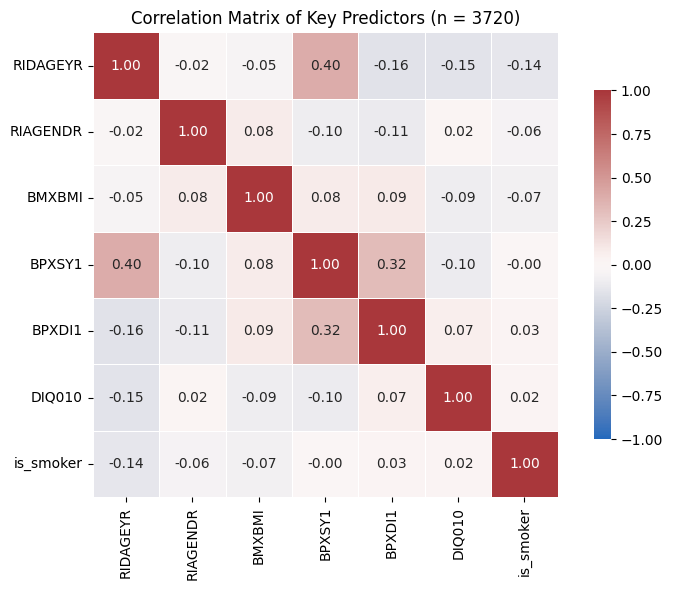

Train=2232, Val=744, Test=744


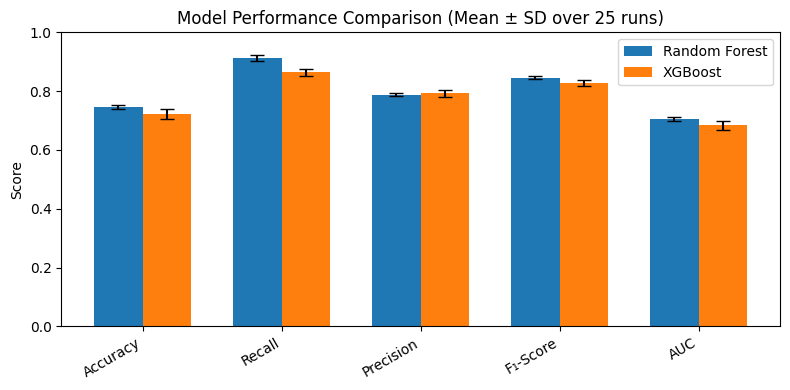

| Model         | Accuracy    | Recall (Severe)   | Precision (Severe)   | F₁-Score (Severe)   | AUC         |
|:--------------|:------------|:------------------|:---------------------|:--------------------|:------------|
| Random Forest | 0.74 ± 0.01 | 0.91 ± 0.01       | 0.79 ± 0.00          | 0.84 ± 0.01         | 0.70 ± 0.01 |
| XGBoost       | 0.72 ± 0.02 | 0.86 ± 0.01       | 0.79 ± 0.01          | 0.83 ± 0.01         | 0.68 ± 0.01 |


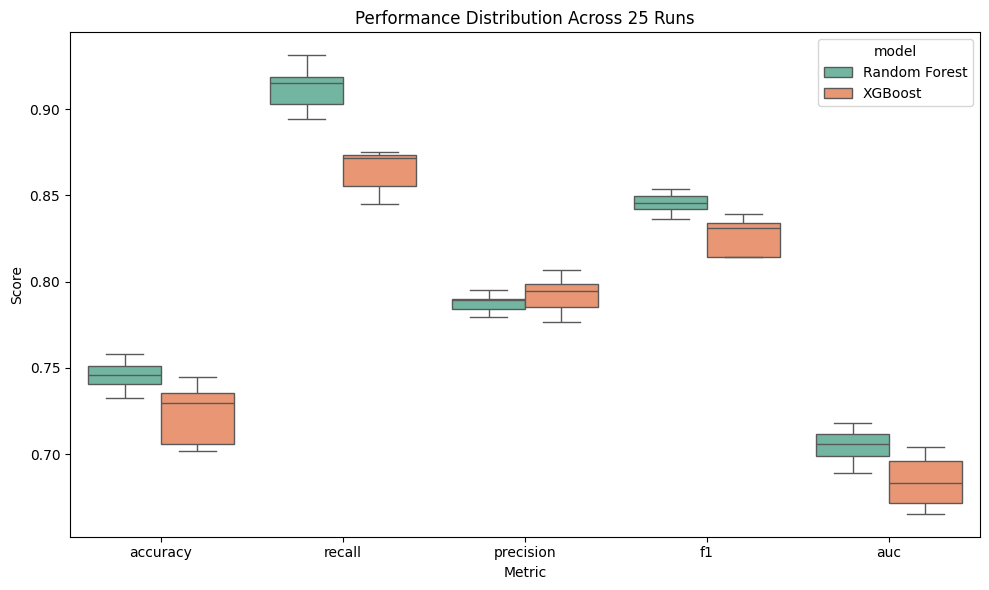

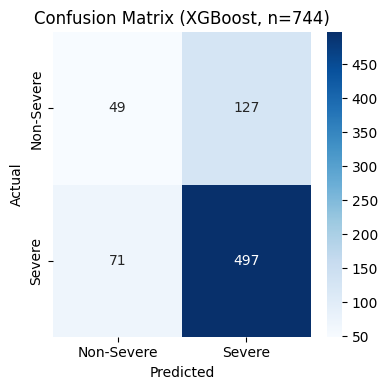

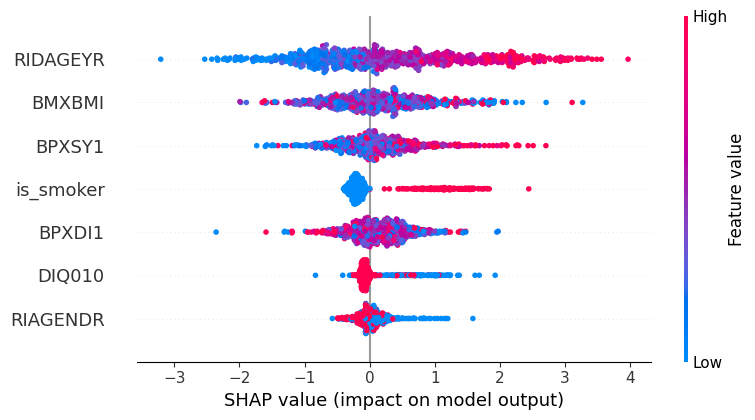

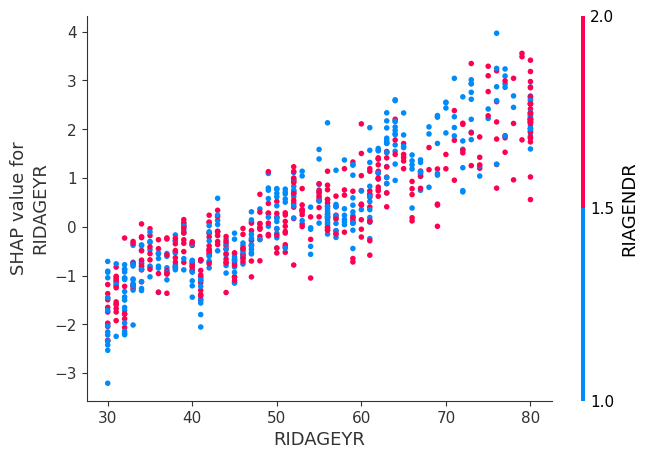

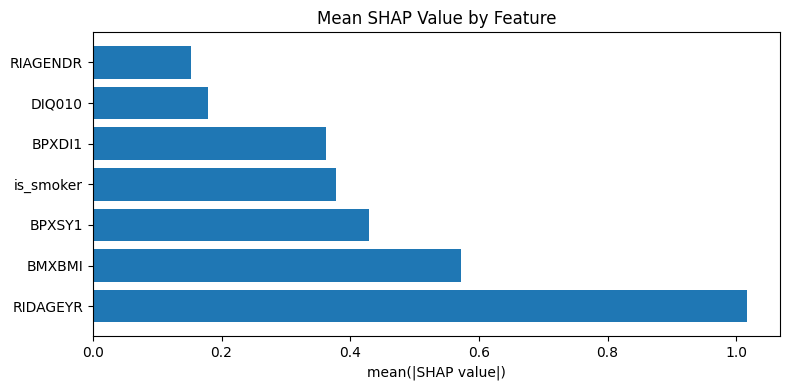

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # CPU only

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Step 1: Load & Clean Data
df = pd.read_csv("final_clean_periodontal_model_dataset.csv")
df = df.drop_duplicates(subset="SEQN").dropna(subset=["mean_PPD","max_PPD"])
df["target"] = (df["max_PPD"] >= 6).astype(int)
features = ["RIDAGEYR","RIAGENDR","BMXBMI","BPXSY1","BPXDI1","DIQ010","is_smoker"]
df_clean = df.dropna(subset=features + ["target"])
print(f"Total clean cases: {len(df_clean)}")

# Step 2: Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[features].corr(), annot=True, fmt=".2f", cmap="vlag",
            vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink":.75})
plt.title(f"Correlation Matrix of Key Predictors (n = {len(df_clean)})")
plt.tight_layout(); plt.show()

# Step 3: 60/20/20 Split
X, y = df_clean[features], df_clean["target"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
print(f"Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

# === Multi‐Seed, Multi‐Trial Evaluation & Bar Chart ===

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Parameters
seeds, trials = [0,1,2,3,4], 5

# Collect results
records = []
for seed in seeds:
    # 60/20/20 split per seed
    Xt, Xts, yt, yts = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=seed
    )
    Xtr, Xv, ytr, yv = train_test_split(
        Xt, yt, test_size=0.25, stratify=yt, random_state=seed
    )
    for t in range(trials):
        # Train Random Forest
        rf = RandomForestClassifier(
            n_estimators=200, max_depth=20,
            class_weight="balanced", random_state=seed+t
        )
        rf.fit(Xtr, ytr)
        y_rf = rf.predict(Xts)
        p_rf = rf.predict_proba(Xts)[:,1]

        # Train XGBoost (default params)
        xgb = XGBClassifier(
            n_estimators=200, max_depth=5,
            eval_metric="logloss", tree_method="hist",
            random_state=seed+t
        )
        xgb.fit(Xtr, ytr)
        y_xgb = xgb.predict(Xts)
        p_xgb = xgb.predict_proba(Xts)[:,1]

        # Record both models’ metrics
        for model_name, y_pred, p in [
            ("Random Forest", y_rf, p_rf),
            ("XGBoost", y_xgb, p_xgb)
        ]:
            records.append({
                "model": model_name,
                "accuracy": accuracy_score(yts, y_pred),
                "recall": recall_score(yts, y_pred),
                "precision": precision_score(yts, y_pred),
                "f1": f1_score(yts, y_pred),
                "auc": roc_auc_score(yts, p)
            })

# Build DataFrame
import pandas as pd
results_multi = pd.DataFrame(records)

# Compute means and stds
metrics = ["accuracy", "recall", "precision", "f1", "auc"]
summary = results_multi.groupby("model")[metrics].agg(["mean","std"]).round(3)

# Extract values for plotting
rf_means   = summary.loc["Random Forest", (slice(None), "mean")].values
rf_stds    = summary.loc["Random Forest", (slice(None), "std")].values
xgb_means  = summary.loc["XGBoost",       (slice(None), "mean")].values
xgb_stds   = summary.loc["XGBoost",       (slice(None), "std")].values

# Labels
metric_labels = ["Accuracy", "Recall", "Precision", "F₁-Score", "AUC"]
x = np.arange(len(metrics))
width = 0.35

# Plot bar chart
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width/2, rf_means,  width, yerr=rf_stds,  capsize=5, label="Random Forest")
ax.bar(x + width/2, xgb_means, width, yerr=xgb_stds, capsize=5, label="XGBoost")

ax.set_xticks(x)
ax.set_xticklabels(metric_labels, rotation=30, ha="right")
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison (Mean ± SD over 25 runs)")
ax.legend()
plt.tight_layout()
plt.show()


# Step 5: Performance Summary Table
metrics = ["accuracy","recall","precision","f1","auc"]
summary = results_multi.groupby("model")[metrics].agg(["mean","std"]).round(3)
table = pd.DataFrame({
    m: summary[(m,"mean")].map("{:.2f}".format) + " ± " + summary[(m,"std")].map("{:.2f}".format)
    for m in metrics
}).reset_index().rename(columns={"model":"Model"})
table.columns = [
    "Model","Accuracy","Recall (Severe)",
    "Precision (Severe)","F₁-Score (Severe)","AUC"
]
print(table.to_markdown(index=False))

# Step 6: Boxplot Distribution
melted = results_multi.melt(id_vars=["model"], value_vars=metrics,
                            var_name="Metric", value_name="Score")
plt.figure(figsize=(10,6))
sns.boxplot(data=melted, x="Metric", y="Score", hue="model", palette="Set2")
plt.title("Performance Distribution Across 25 Runs")
plt.tight_layout(); plt.show()

# Step 7: Confusion Matrix (XGBoost)
final_xgb = XGBClassifier(
    n_estimators=200, max_depth=5,
    eval_metric="logloss", tree_method="hist",
    random_state=42
)
final_xgb.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
cm = confusion_matrix(y_test, final_xgb.predict(X_test))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Severe","Severe"],
            yticklabels=["Non-Severe","Severe"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost, n=744)")
plt.tight_layout(); plt.show()

# Step 8 & 9: SHAP Explanations (wrapped)
try:
    import shap
    explainer = shap.TreeExplainer(final_xgb)
    sv = explainer.shap_values(X_test)
    shap.summary_plot(sv, X_test)
    shap.dependence_plot("RIDAGEYR", sv, X_test, interaction_index="RIAGENDR")
    # Mean SHAP bar chart
    mean_abs_shap = np.abs(sv).mean(axis=0)
    idx = np.argsort(mean_abs_shap)
    feat_sorted = [features[i] for i in idx]
    imp_sorted = mean_abs_shap[idx]
    plt.figure(figsize=(8,4))
    plt.barh(feat_sorted, imp_sorted, color='tab:blue')
    plt.xlabel('mean(|SHAP value|)')
    plt.title('Mean SHAP Value by Feature')
    plt.gca().invert_yaxis()
    plt.tight_layout(); plt.show()
except Exception as e:
    print("SHAP steps skipped due to:", e)
